# Representation Learning and Property Matching for Thermodynamic Systems

Learn a representation of a thermodynamic system by training a system classifier and use the learned thermodynamic space for property (temperature, ferromagnetic/antiferromagnetic) learning

## Table of Contents

* [1. Data Processing](#1.-Data-Processing)
* [2. Representation Learning](#2.-Representation-Learning)
* [3. Learning and Predicting System Properties](#3.-Learning-and-Predicting-System-Properties)

In [1]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product, combinations
import pickle
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from cycler import cycler

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, ReLU, Softmax
from tensorflow.keras.layers import Lambda, Embedding, LeakyReLU, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# local library for data processing
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

sys.path.append('../src')
from model import plot_ternary, plot_ternary_continuum, trace_loss, variance_loss

In [4]:
# Test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Processing

### Load data from MC simulations

In [5]:
sim_dir = '../sim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a100', 'a20', 'a10', 'a5', 'a2', 'a1'])  # antiferromagnetic

In [6]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a100', 'a20', 'a10', 'a5', 'a2', 'a1'])
1000


In [7]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

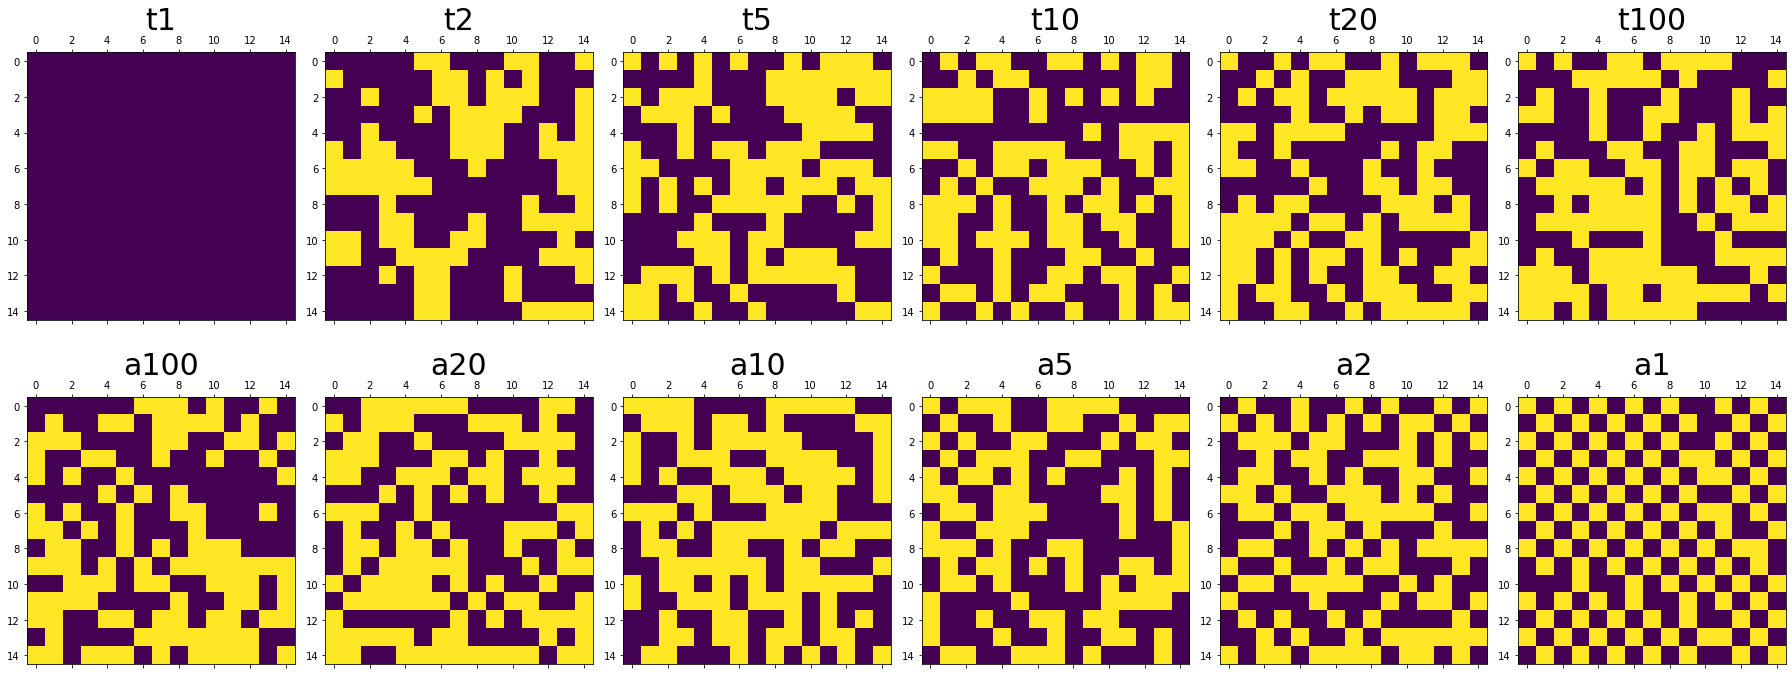

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [9]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Dimensions of the embedding space
z_dim = 3

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

Input image shape:  (15, 15, 1)
Feature space dimension:  3


## 2. Representation Learning

Discriminate between different Ising systems by embedding each system into a probability space and optimizing classification in this space. Another (better) option is to maximize between-class/within-class variance ratio (as in Fisher/Linear Discriminant Analysis). This would directly optimize statistical distances.

### 2.1 Model definitions

In [174]:
def build_embedding(img_shape, nfilt, ndim, activation='relu'):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    img_shape: tuple
        Shape of the input data
    nfilt: int
        Number of filters in the first layer
    ndim: int
        Embedding dimension
    """
    #initializer = tf.keras.initializers.Orthogonal()
    initializer = 'lecun_normal'

    model = Sequential()
    model.add(Conv2D(nfilt, kernel_size=3, kernel_initializer=initializer, strides=2, padding='valid',
                     input_shape=img_shape))
    model.add(Activation(activation))
    model.add(Conv2D(ndim, kernel_size=1, kernel_initializer=initializer, strides=1, padding='valid'))
    model.add(Softmax())
    # Assuming indpendent local conigurations, create a unit vector for the whole configuration
    model.add(GlobalAveragePooling2D())  
    model.add(Lambda(lambda x: tf.math.sqrt(x)))

    return model

In [175]:
def build_classifier(nclass):
    """Build a simple linear logistic regression classifier on the probability space.
    
    Arguments
    ---------
    nclass: int
        Number of classes
    """

    model = Sequential()
    model.add(Dense(nclass))
    model.add(Softmax())
    
    return model

In [176]:
def build_discriminator(mdl_embed, mdl_class):
    """Combine embedding and classification modules"""
 
    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_class)
    
    return model

### 2.2 Training data preparation

In [177]:
# Set up training data
data_list = [np.expand_dims(np.array(cfgs[t][:]), axis=-1) for t in temps]#["t1", "t100", "a1"]]

In [178]:
# Flip half of t1 configurations
dd = data_list[0]
dd[:500] = 1 - dd[:500]
data_list[0] = dd

In [179]:
data_train = np.concatenate(data_list, axis=0)
data_train.shape

(12000, 15, 15, 1)

In [180]:
# Set up labels
#data_out = np.concatenate([mm(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
labels.shape

(12000,)

In [181]:
# Shuffle data
idx = np.random.permutation(len(labels)) # mix them a bit
data_train = data_train[idx]
labels = labels[idx]
labels_tf = tf.convert_to_tensor(labels, dtype=tf.int32)
data_train.shape, labels_tf.shape

((12000, 15, 15, 1), TensorShape([12000]))

### 2.3 Model building, compiling, and training

**Define loss function for representation learning**

In [182]:
# Build embedding
mdl_embed = build_embedding(img_shape, nfilt=8, ndim=3, activation='relu')

# Build classification layers on top of embedding to train the embedder
mdl_class = build_classifier(nclass=len(np.unique(labels)))

# Connect embedding and classification for representation learning
mdl_train = build_discriminator(mdl_embed, mdl_class)

optimizer = Adam()

In [183]:
mdl_embed.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 7, 7, 8)           80        
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 3)           27        
_________________________________________________________________
softmax_6 (Softmax)          (None, 7, 7, 3)           0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 3)                 0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 3)                 0         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_______________________________________________________

In [184]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
mdl_train.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
history = mdl_train.fit(data_train, labels_tf, batch_size=120, epochs=2000, verbose=1)

Epoch 1/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.5183 - accuracy: 0.0789
Epoch 2/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4873 - accuracy: 0.0818
Epoch 3/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4774 - accuracy: 0.0871
Epoch 4/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4723 - accuracy: 0.0986
Epoch 5/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4664 - accuracy: 0.0965
Epoch 6/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4597 - accuracy: 0.1265
Epoch 7/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4509 - accuracy: 0.1595
Epoch 8/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4386 - accuracy: 0.1777
Epoch 9/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.4211 - accuracy: 0.1826
Epoch 10/2000
100/100 [==============================] - 0s 1ms/step - loss: 2.400

100/100 [==============================] - 0s 1ms/step - loss: 1.6088 - accuracy: 0.4823
Epoch 81/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5811 - accuracy: 0.4950
Epoch 82/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5727 - accuracy: 0.4948
Epoch 83/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5712 - accuracy: 0.5003
Epoch 84/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.5700 - accuracy: 0.5040
Epoch 85/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5655 - accuracy: 0.4964
Epoch 86/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5646 - accuracy: 0.4939
Epoch 87/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5601 - accuracy: 0.4952
Epoch 88/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5582 - accuracy: 0.4970
Epoch 89/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.5491 - a

100/100 [==============================] - 0s 1ms/step - loss: 1.3453 - accuracy: 0.5390
Epoch 160/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3596 - accuracy: 0.5277
Epoch 161/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3508 - accuracy: 0.5285
Epoch 162/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3390 - accuracy: 0.5360
Epoch 163/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3522 - accuracy: 0.5246
Epoch 164/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3522 - accuracy: 0.5355
Epoch 165/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3435 - accuracy: 0.5366
Epoch 166/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3478 - accuracy: 0.5278
Epoch 167/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.3557 - accuracy: 0.5272
Epoch 168/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.2503 - accuracy: 0.5467
Epoch 238/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2620 - accuracy: 0.5347
Epoch 239/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2701 - accuracy: 0.5369
Epoch 240/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2511 - accuracy: 0.5440
Epoch 241/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2636 - accuracy: 0.5397
Epoch 242/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2473 - accuracy: 0.5494
Epoch 243/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2519 - accuracy: 0.5501
Epoch 244/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2462 - accuracy: 0.5424
Epoch 245/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2551 - accuracy: 0.5424
Epoch 246/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1992 - accuracy: 0.5515
Epoch 316/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2037 - accuracy: 0.5507
Epoch 317/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2139 - accuracy: 0.5453
Epoch 318/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2104 - accuracy: 0.5455
Epoch 319/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1903 - accuracy: 0.5512
Epoch 320/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2109 - accuracy: 0.5435
Epoch 321/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2213 - accuracy: 0.5419
Epoch 322/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1996 - accuracy: 0.5523
Epoch 323/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.2142 - accuracy: 0.5402
Epoch 324/2000
100/100 [==============================] - 0s 2ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1669 - accuracy: 0.5584
Epoch 394/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1813 - accuracy: 0.5480
Epoch 395/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1883 - accuracy: 0.5397
Epoch 396/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1755 - accuracy: 0.5485
Epoch 397/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1764 - accuracy: 0.5478
Epoch 398/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1928 - accuracy: 0.5400
Epoch 399/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1761 - accuracy: 0.5495
Epoch 400/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1728 - accuracy: 0.5461
Epoch 401/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1802 - accuracy: 0.5396
Epoch 402/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1580 - accuracy: 0.5525
Epoch 472/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1522 - accuracy: 0.5505
Epoch 473/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1539 - accuracy: 0.5519
Epoch 474/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1525 - accuracy: 0.5484
Epoch 475/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1602 - accuracy: 0.5491
Epoch 476/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1506 - accuracy: 0.5520
Epoch 477/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1464 - accuracy: 0.5547
Epoch 478/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1486 - accuracy: 0.5536
Epoch 479/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1596 - accuracy: 0.5425
Epoch 480/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1322 - accuracy: 0.5538
Epoch 550/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1419 - accuracy: 0.5509
Epoch 551/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1466 - accuracy: 0.5544
Epoch 552/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1349 - accuracy: 0.5604
Epoch 553/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1263 - accuracy: 0.5632
Epoch 554/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1510 - accuracy: 0.5468
Epoch 555/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1474 - accuracy: 0.5438
Epoch 556/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1492 - accuracy: 0.5426
Epoch 557/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1391 - accuracy: 0.5529
Epoch 558/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1161 - accuracy: 0.5590
Epoch 628/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1188 - accuracy: 0.5581
Epoch 629/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1345 - accuracy: 0.5487
Epoch 630/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1242 - accuracy: 0.5536
Epoch 631/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1178 - accuracy: 0.5522
Epoch 632/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1353 - accuracy: 0.5457
Epoch 633/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1165 - accuracy: 0.5587
Epoch 634/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1155 - accuracy: 0.5583
Epoch 635/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1222 - accuracy: 0.5560
Epoch 636/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1213 - accuracy: 0.5549
Epoch 706/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1172 - accuracy: 0.5558
Epoch 707/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1170 - accuracy: 0.5542
Epoch 708/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1180 - accuracy: 0.5589
Epoch 709/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1126 - accuracy: 0.5602
Epoch 710/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1263 - accuracy: 0.5545
Epoch 711/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1192 - accuracy: 0.5523
Epoch 712/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1201 - accuracy: 0.5485
Epoch 713/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1160 - accuracy: 0.5546
Epoch 714/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1104 - accuracy: 0.5554
Epoch 784/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1171 - accuracy: 0.5471
Epoch 785/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0998 - accuracy: 0.5563
Epoch 786/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0982 - accuracy: 0.5612
Epoch 787/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1113 - accuracy: 0.5541
Epoch 788/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1185 - accuracy: 0.5461
Epoch 789/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1006 - accuracy: 0.5563
Epoch 790/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1067 - accuracy: 0.5527
Epoch 791/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1285 - accuracy: 0.5458
Epoch 792/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.0975 - accuracy: 0.5563
Epoch 862/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0957 - accuracy: 0.5539
Epoch 863/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0944 - accuracy: 0.5551
Epoch 864/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1175 - accuracy: 0.5452
Epoch 865/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0895 - accuracy: 0.5626
Epoch 866/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0917 - accuracy: 0.5637
Epoch 867/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.1117 - accuracy: 0.5518
Epoch 868/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1153 - accuracy: 0.5470
Epoch 869/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1093 - accuracy: 0.5556
Epoch 870/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.1017 - accuracy: 0.5532
Epoch 940/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0980 - accuracy: 0.5570
Epoch 941/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0976 - accuracy: 0.5593
Epoch 942/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0923 - accuracy: 0.5518
Epoch 943/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0885 - accuracy: 0.5564
Epoch 944/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1032 - accuracy: 0.5552
Epoch 945/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1028 - accuracy: 0.5494
Epoch 946/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1022 - accuracy: 0.5528
Epoch 947/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0953 - accuracy: 0.5590
Epoch 948/2000
100/100 [==============================] - 0s 1ms/step - loss: 1

100/100 [==============================] - 0s 1ms/step - loss: 1.0862 - accuracy: 0.5607
Epoch 1018/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0896 - accuracy: 0.5534
Epoch 1019/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0858 - accuracy: 0.5638
Epoch 1020/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0867 - accuracy: 0.5566
Epoch 1021/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0941 - accuracy: 0.5574
Epoch 1022/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.1004 - accuracy: 0.5523
Epoch 1023/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0914 - accuracy: 0.5588
Epoch 1024/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0915 - accuracy: 0.5540
Epoch 1025/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0794 - accuracy: 0.5592
Epoch 1026/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0985 - accuracy: 0.5486
Epoch 1096/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0839 - accuracy: 0.5590
Epoch 1097/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0831 - accuracy: 0.5535
Epoch 1098/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0824 - accuracy: 0.5563
Epoch 1099/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0851 - accuracy: 0.5605
Epoch 1100/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0940 - accuracy: 0.5584
Epoch 1101/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0883 - accuracy: 0.5552
Epoch 1102/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0818 - accuracy: 0.5618
Epoch 1103/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0887 - accuracy: 0.5583
Epoch 1104/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0883 - accuracy: 0.5546
Epoch 1173/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0866 - accuracy: 0.5581
Epoch 1174/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0764 - accuracy: 0.5642
Epoch 1175/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0827 - accuracy: 0.5576
Epoch 1176/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0743 - accuracy: 0.5627
Epoch 1177/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0836 - accuracy: 0.5611
Epoch 1178/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0990 - accuracy: 0.5487
Epoch 1179/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0816 - accuracy: 0.5639
Epoch 1180/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0797 - accuracy: 0.5559
Epoch 1181/2000
100/100 [==============================] - 0s 2ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0888 - accuracy: 0.5572
Epoch 1251/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0970 - accuracy: 0.5523
Epoch 1252/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0712 - accuracy: 0.5677
Epoch 1253/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0737 - accuracy: 0.5680
Epoch 1254/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0843 - accuracy: 0.5599
Epoch 1255/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0830 - accuracy: 0.5573
Epoch 1256/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0793 - accuracy: 0.5549
Epoch 1257/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0920 - accuracy: 0.5566
Epoch 1258/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0973 - accuracy: 0.5539
Epoch 1259/2000
100/100 [==============================] - 0s 2ms/step 

100/100 [==============================] - 0s 2ms/step - loss: 1.0809 - accuracy: 0.5618
Epoch 1329/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0814 - accuracy: 0.5569
Epoch 1330/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0950 - accuracy: 0.5500
Epoch 1331/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0746 - accuracy: 0.5631
Epoch 1332/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0790 - accuracy: 0.5581
Epoch 1333/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0775 - accuracy: 0.5655
Epoch 1334/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0700 - accuracy: 0.5647
Epoch 1335/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0852 - accuracy: 0.5559
Epoch 1336/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0824 - accuracy: 0.5571
Epoch 1337/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 2ms/step - loss: 1.0811 - accuracy: 0.5561
Epoch 1407/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0855 - accuracy: 0.5536
Epoch 1408/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0878 - accuracy: 0.5525
Epoch 1409/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0789 - accuracy: 0.5540
Epoch 1410/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0715 - accuracy: 0.5592
Epoch 1411/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0869 - accuracy: 0.5551
Epoch 1412/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0706 - accuracy: 0.5573
Epoch 1413/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0687 - accuracy: 0.5617
Epoch 1414/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0817 - accuracy: 0.5565
Epoch 1415/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 2ms/step - loss: 1.0804 - accuracy: 0.5552
Epoch 1485/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0772 - accuracy: 0.5621
Epoch 1486/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0776 - accuracy: 0.5602
Epoch 1487/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0868 - accuracy: 0.5516
Epoch 1488/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0866 - accuracy: 0.5581
Epoch 1489/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0806 - accuracy: 0.5600
Epoch 1490/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0728 - accuracy: 0.5572
Epoch 1491/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0779 - accuracy: 0.5582
Epoch 1492/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0875 - accuracy: 0.5607
Epoch 1493/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0698 - accuracy: 0.5610
Epoch 1562/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0785 - accuracy: 0.5603
Epoch 1563/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0722 - accuracy: 0.5591
Epoch 1564/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0834 - accuracy: 0.5560
Epoch 1565/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0674 - accuracy: 0.5618
Epoch 1566/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0765 - accuracy: 0.5648
Epoch 1567/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0717 - accuracy: 0.5648
Epoch 1568/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0881 - accuracy: 0.5529
Epoch 1569/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0878 - accuracy: 0.5579
Epoch 1570/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0789 - accuracy: 0.5500
Epoch 1639/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0717 - accuracy: 0.5620
Epoch 1640/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0962 - accuracy: 0.5480
Epoch 1641/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0753 - accuracy: 0.5606
Epoch 1642/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0655 - accuracy: 0.5584
Epoch 1643/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0840 - accuracy: 0.5501
Epoch 1644/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0749 - accuracy: 0.5552
Epoch 1645/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0755 - accuracy: 0.5587
Epoch 1646/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0684 - accuracy: 0.5602
Epoch 1647/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 2ms/step - loss: 1.0657 - accuracy: 0.5603
Epoch 1717/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0777 - accuracy: 0.5574
Epoch 1718/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0836 - accuracy: 0.5568
Epoch 1719/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0747 - accuracy: 0.5565
Epoch 1720/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0683 - accuracy: 0.5604
Epoch 1721/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0638 - accuracy: 0.5626
Epoch 1722/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0754 - accuracy: 0.5626
Epoch 1723/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0624 - accuracy: 0.5632
Epoch 1724/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0762 - accuracy: 0.5567
Epoch 1725/2000
100/100 [==============================] - 0s 2ms/step 

100/100 [==============================] - 0s 2ms/step - loss: 1.0618 - accuracy: 0.5639
Epoch 1794/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0789 - accuracy: 0.5550
Epoch 1795/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0623 - accuracy: 0.5644
Epoch 1796/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0781 - accuracy: 0.5559
Epoch 1797/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0689 - accuracy: 0.5616
Epoch 1798/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0746 - accuracy: 0.5593
Epoch 1799/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0601 - accuracy: 0.5673
Epoch 1800/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0800 - accuracy: 0.5535
Epoch 1801/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0775 - accuracy: 0.5580
Epoch 1802/2000
100/100 [==============================] - 0s 1ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0732 - accuracy: 0.5586
Epoch 1871/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0694 - accuracy: 0.5600
Epoch 1872/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0718 - accuracy: 0.5605
Epoch 1873/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0677 - accuracy: 0.5627
Epoch 1874/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0664 - accuracy: 0.5625
Epoch 1875/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0660 - accuracy: 0.5507
Epoch 1876/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0693 - accuracy: 0.5610
Epoch 1877/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0622 - accuracy: 0.5634
Epoch 1878/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0718 - accuracy: 0.5564
Epoch 1879/2000
100/100 [==============================] - 0s 2ms/step 

100/100 [==============================] - 0s 1ms/step - loss: 1.0681 - accuracy: 0.5566
Epoch 1949/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0669 - accuracy: 0.5618
Epoch 1950/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0703 - accuracy: 0.5625
Epoch 1951/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0576 - accuracy: 0.5622
Epoch 1952/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0706 - accuracy: 0.5570
Epoch 1953/2000
100/100 [==============================] - 0s 1ms/step - loss: 1.0674 - accuracy: 0.5616
Epoch 1954/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.5611
Epoch 1955/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0691 - accuracy: 0.5612
Epoch 1956/2000
100/100 [==============================] - 0s 2ms/step - loss: 1.0737 - accuracy: 0.5610
Epoch 1957/2000
100/100 [==============================] - 0s 2ms/step 

In [185]:
# loss = variance_loss()
# mdl_embed.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
# history = mdl_embed.fit(data_train, labels_tf, batch_size=120, epochs=50, verbose=1)

### 2.4 Model performance

Text(0.5, 0.98, 'Optimization History')

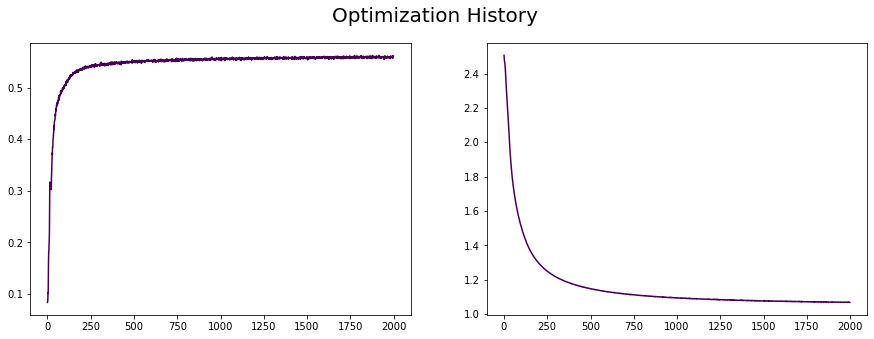

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [187]:
# Set up training data and lables
data_out = np.concatenate([mdl_embed(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels_out = np.concatenate(class_list, axis=0)
data_out.shape, labels_out.shape

((12000, 3), (12000,))

In [188]:
if data_out.shape[1] == 2:
    do = data_out[:,0]**2
    dd = np.vstack([do, labels_out]).T
    for c in np.unique(labels_out):
        indx = np.where(dd[:, 1] == c)
        print(np.mean(dd[indx, 0]))

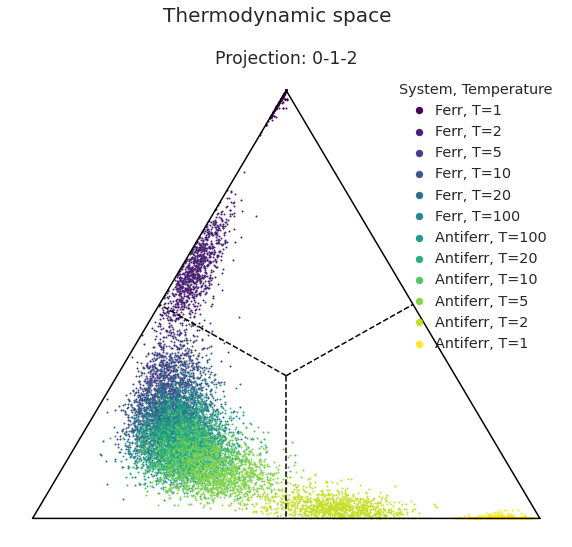

In [189]:
trslt = {'t':'Ferr', 'a':"Antiferr"}
cnames = [f'{trslt[t[0]]}, T={t[1:]}' for t in temps]
plot_ternary(data_out[idx]**2, labels_out[idx], np.unique(labels_out), class_names = cnames, plt_title = "Thermodynamic space",
             size=10)

**Calculate maximum likelihood estimates of multinomial distributions for each class**

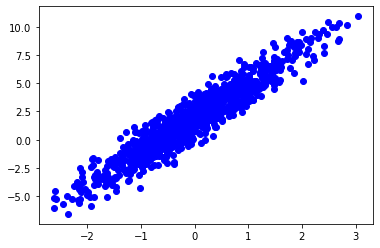

In [246]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise

# Plot all the data
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()

In [247]:
class MyModel(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Initialize the weights to `5.0` and the bias to `0.0`
        # In practice, these should be randomly initialized
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


In [256]:
def ll_multinom(target_y, predicted_y):
    """Calculate multinomial loglikelihood"""
    
    return tf.reduce_mean(tf.square(target_y - predicted_y))

In [272]:
neff = tf.Variable(10.0, name='n_eff', dtype=tf.float32)
pr = tf.Variable(np.ones(3), name='probs', dtype=tf.float32)


with tf.GradientTape() as t:
    mll = 2*tf.math.lgamma(neff) + neff*tf.math.log(pr)
    


In [273]:
dneff, dpr = t.gradient(mll, [neff, pr])

In [274]:
dneff, dpr

(<tf.Tensor: shape=(), dtype=float32, numpy=13.510515>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([10., 10., 10.], dtype=float32)>)

In [266]:
# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)

# Define a training loop
def training_loop(model, x, y):
    
    learning_rate = 1e-3

    for epoch in epochs:
        # Update the model with the single giant batch
        train(model, x, y, learning_rate=0.1)
        
        with tf.GradientTape() as t:
            # Trainable variables are automatically tracked by GradientTape
            mll = 2*tf.math.lgamma(neff) + neff*tf.math.log(pr)

            # Use GradientTape to calculate the gradients with respect to W and b
            dneff, dpr = t.gradient(mll, [neff, pr])

        # Subtract the gradient scaled by the learning rate
        neff.assign_sub(learning_rate * dneff)
        pr.assign_sub(learning_rate * dpr)

        current_loss = loss(y, model(x))

        print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" % (epoch, Ws[-1], bs[-1], current_loss))

RuntimeError: A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)

In [ ]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):


    with tf.GradientTape() as t:
        # Trainable variables are automatically tracked by GradientTape
        current_loss = loss(y, model(x))

    # Use GradientTape to calculate the gradients with respect to W and b
    dw, db = t.gradient(current_loss, [model.w, model.b])

    # Subtract the gradient scaled by the learning rate
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

In [ ]:
def multinom_ml_estimate(data):

    k = data.shape[-1]

    with tf.GradientTape as tape:
        
        
    
    return params

In [243]:
def get_estimates(data, labels):
    params = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)
        dd = data[idx, :]**2  # sample probabilities
        p = multinom_ml_estimate(dd)
        params[c] = p    

    return params

In [244]:
get_estimates(data_out, labels_out)

{0: {'a': 1, 'b': 2},
 1: {'a': 1, 'b': 2},
 2: {'a': 1, 'b': 2},
 3: {'a': 1, 'b': 2},
 4: {'a': 1, 'b': 2},
 5: {'a': 1, 'b': 2},
 6: {'a': 1, 'b': 2},
 7: {'a': 1, 'b': 2},
 8: {'a': 1, 'b': 2},
 9: {'a': 1, 'b': 2},
 10: {'a': 1, 'b': 2},
 11: {'a': 1, 'b': 2}}

<IPython.core.display.Javascript object>


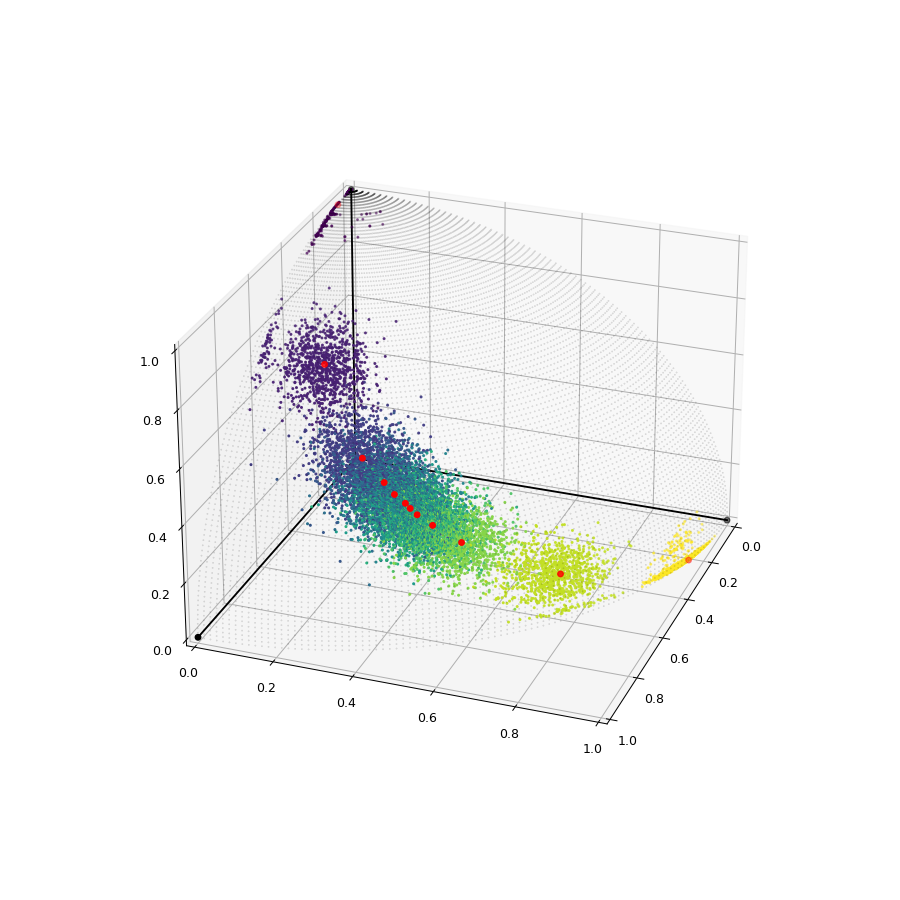

(0.0, 1.0)

In [192]:
%matplotlib notebook
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi/2:100j, 0.0:pi/2:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Import data
#data = np.genfromtxt('leb.txt')
data = data_out[:,:3]
xx, yy, zz = np.hsplit(data, 3) 

#Set colours and render

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter([0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], c='k')
ax.plot([0, 0], [0, 0], [0, 1], c='k')
ax.plot([0, 0], [0, 1], [0, 0], c='k')
ax.plot([0, 1], [0, 0], [0, 0], c='k')

#ax.plot_surface(x, y, z, rstride=1, cstride=1, color='c', alpha=0.6, linewidth=0)
ax.scatter(x, y, z, color='k', alpha=0.2, s=0.1)

# Plot vectors on the sphere surface
ax.scatter(xx, yy, zz, c=labels_out, s=2)

# Plot class centroids
cents = []
for c in np.unique(labels_out):
    index = np.where(labels_out == c)
    xc = np.sqrt(np.mean(data[index, 0]**2))
    yc = np.sqrt(np.mean(data[index, 1]**2))
    zc = np.sqrt(np.mean(data[index, 2]**2))
    cents.append([xc, yc, zc, c])
cents = np.array(cents)*1.02
ax.scatter(cents[:,0], cents[:,1], cents[:,2], color="red", s=20)

#ax.scatter(cents[:,0], cents[:,1], cents[:,2], c=cents[:,3].astype(np.int), s=20)


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])
#ax.set_aspect("equal")
#plt.tight_layout()

In [193]:
%matplotlib inline
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi/2:100j, 0.0:pi/2:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Import data
#data = np.genfromtxt('leb.txt')
data = data_out[:,:4]**2
#idx = np.where(labels == cl)
a = data[:, 0]
b = data[:, 1]
c = data[:, 2]
xx = 0.5 * ( 2.*b+c ) / ( a+b+c )*1
yy = 0.5*np.sqrt(3) * c / (a+b+c)*1
zz = data[:, 3]
#xx, yy, zz = np.hsplit(data, 3)

#Set colours and render

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter([0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], c='k')
ax.plot([0, 1], [0, 0], [0, 0], c='k')
ax.plot([0, 0.5], [0, np.sqrt(1 - 0.5**2)], [0, 0], c='k')
ax.plot([1, 0.5], [0, np.sqrt(1 - 0.5**2)], [0, 0], c='k')


# #ax.plot_surface(x, y, z, rstride=1, cstride=1, color='c', alpha=0.6, linewidth=0)
# ax.scatter(x, y, z, color='k', alpha=0.2, s=0.1)

# Plot vectors on the sphere surface
ax.scatter(xx, yy, zz, c=labels_out, s=2)

# # Plot class centroids
# cents = []
# for c in np.unique(labels_out):
#     index = np.where(labels_out == c)
#     xc = np.sqrt(np.mean(data[index, 0]**2))
#     yc = np.sqrt(np.mean(data[index, 1]**2))
#     zc = np.sqrt(np.mean(data[index, 2]**2))
#     cents.append([xc, yc, zc, c])
# cents = np.array(cents)*1.02
# ax.scatter(cents[:,0], cents[:,1], cents[:,2], color="red", s=20)

#ax.scatter(cents[:,0], cents[:,1], cents[:,2], c=cents[:,3].astype(np.int), s=20)


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])
#ax.set_aspect("equal")
#plt.tight_layout()

IndexError: index 3 is out of bounds for axis 1 with size 3

## 3. Learning and Predicting System Properties

Learn mapping between the trained embedding (thermodynamic) space and physical properties

### 3.1 System temperature

#### 3.1.1 Model and its training

In [194]:
def build_temp_layers(nunit):
    """Determine temperature of the system generating given configurations.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Lambda(lambda x: tf.math.exp(x)))
    
    return model

In [195]:
def build_property_learn(mdl_embed, mdl_prop):
 
    mdl_embed.trainable = False

    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_prop)

    return model

In [196]:
mdl_temp_layers = build_temp_layers(6)
mdl_temp = build_property_learn(mdl_embed, mdl_temp_layers)

In [197]:
mdl_temp.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['MAE'], optimizer=Adam())

In [198]:
temp_list = [np.array(len(cfg)*[1/float(t[1:])]) for t, cfg in zip(temps, data_list)]
y_temp = np.concatenate(temp_list, axis=0)
y_temp.shape
y_temp = y_temp[idx]

In [199]:
history = mdl_temp.fit(data_train, y_temp, batch_size=240, epochs=500, verbose=1)

Epoch 1/500
50/50 [==============================] - 0s 1ms/step - loss: 0.5625 - MAE: 0.6935
Epoch 2/500
50/50 [==============================] - 0s 1ms/step - loss: 0.3696 - MAE: 0.5533
Epoch 3/500
50/50 [==============================] - 0s 1ms/step - loss: 0.2292 - MAE: 0.4236
Epoch 4/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1679 - MAE: 0.3439
Epoch 5/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1425 - MAE: 0.2956
Epoch 6/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1295 - MAE: 0.2623
Epoch 7/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1227 - MAE: 0.2413
Epoch 8/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1184 - MAE: 0.2275
Epoch 9/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1137 - MAE: 0.2096
Epoch 10/500
50/50 [==============================] - 0s 1ms/step - loss: 0.1084 - MAE: 0.1942
Epoch 11/500
50/50 [==============================] - 0s 1m

50/50 [==============================] - 0s 1ms/step - loss: 0.0036 - MAE: 0.0448
Epoch 88/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0443
Epoch 89/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0443
Epoch 90/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0439
Epoch 91/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0445
Epoch 92/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0444
Epoch 93/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0439
Epoch 94/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0440
Epoch 95/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0442
Epoch 96/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0035 - MAE: 0.0438
Epoch 97/500
50/50 [==============================] - 0s 1ms/st

50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0415
Epoch 173/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0411
Epoch 174/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0416
Epoch 175/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0033 - MAE: 0.0421
Epoch 176/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0418
Epoch 177/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0416
Epoch 178/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0413
Epoch 179/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0033 - MAE: 0.0421
Epoch 180/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0418
Epoch 181/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0034 - MAE: 0.0424
Epoch 182/500
50/50 [==============================] -

50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0411
Epoch 258/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0413
Epoch 259/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0416
Epoch 260/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0404
Epoch 261/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0404
Epoch 262/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0409
Epoch 263/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0406
Epoch 264/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0402
Epoch 265/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0404
Epoch 266/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0413
Epoch 267/500
50/50 [==============================] -

50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0411
Epoch 343/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0030 - MAE: 0.0398
Epoch 344/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0406
Epoch 345/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0400
Epoch 346/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0407
Epoch 347/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0408
Epoch 348/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0406
Epoch 349/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0405
Epoch 350/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0030 - MAE: 0.0396
Epoch 351/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0404
Epoch 352/500
50/50 [==============================] -

50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0405
Epoch 428/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0400
Epoch 429/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0030 - MAE: 0.0395
Epoch 430/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0407
Epoch 431/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0403
Epoch 432/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0405
Epoch 433/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0031 - MAE: 0.0399
Epoch 434/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0030 - MAE: 0.0399
Epoch 435/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0030 - MAE: 0.0395
Epoch 436/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0032 - MAE: 0.0410
Epoch 437/500
50/50 [==============================] -

#### 3.1.2 Evaluation and predictions

Text(0.5, 0.98, 'Optimization History')

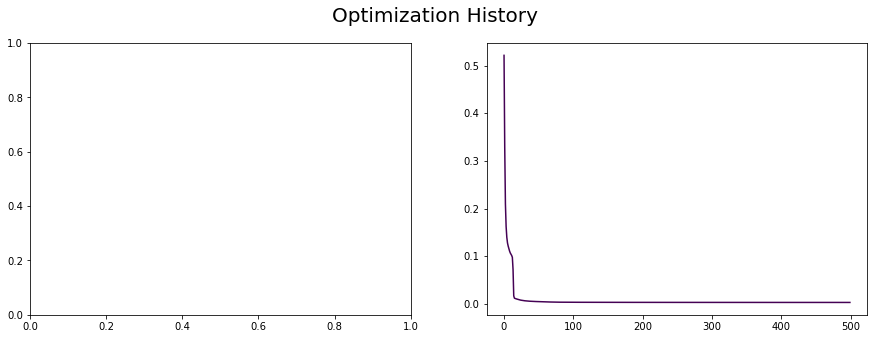

In [200]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [201]:
y_pred = mdl_temp.predict(data_train)

Text(0.5, 1.0, 'Histograms of inverse temperatures: simulations vs. predictions')

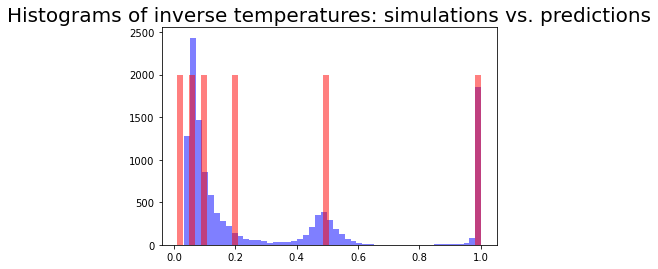

In [202]:
%matplotlib inline
_ = plt.hist(np.ravel(y_pred), color='b', alpha=0.5, bins=50, label="Predicted")
_ = plt.hist(np.ravel(y_temp), color='r', alpha=0.5, bins=50, label="Simulated")
plt.title("Histograms of inverse temperatures: simulations vs. predictions", fontsize=20)

Text(0.5, 1.0, 'Predicted vs. simulated inverse temperature')

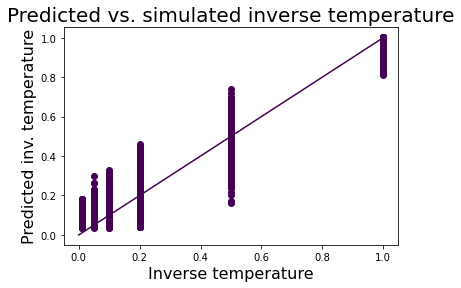

In [203]:
plt.scatter(np.ravel(y_temp), np.ravel(y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("Inverse temperature", fontsize=16)
plt.ylabel("Predicted inv. temperature", fontsize=16)
plt.title("Predicted vs. simulated inverse temperature", fontsize=20)

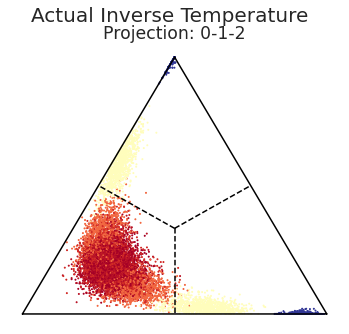

In [204]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(y_temp), size=6, plt_title = "Actual Inverse Temperature")

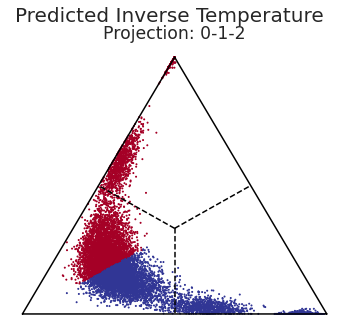

In [214]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(y_pred), size=6, plt_title = "Predicted Inverse Temperature")

### 3.2 System type: Ferromagnetic vs. Antiferromagnetic

#### 3.2.1 Model and its training

In [206]:
def build_system_id_layers(ndim):
    """Classify configurations as coming from ferromagnetic or antiferromagnetic systems
        
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
       
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(ndim))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [207]:
mdl_sysid_layers = build_system_id_layers(ndim = 4)
mdl_sysid = build_property_learn(mdl_embed, mdl_sysid_layers)

In [208]:
mdl_sysid.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [209]:
sysid_list = [np.array(len(cfg)*[int(t[0] == "a")]) for t, cfg in zip(temps, data_list)]
y_sysid = np.concatenate(sysid_list, axis=0)
y_sysid = np.expand_dims(y_sysid, axis=-1)
y_sysid.shape
y_sysid = y_sysid[idx]

In [210]:
history = mdl_sysid.fit(data_train, y_sysid, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 0.7355 - accuracy: 0.5735
Epoch 2/100
375/375 [==============================] - 0s 1ms/step - loss: 0.4032 - accuracy: 0.8508
Epoch 3/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8543
Epoch 4/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3191 - accuracy: 0.8602
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.8532
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3054 - accuracy: 0.8546
Epoch 7/100
375/375 [==============================] - 1s 1ms/step - loss: 0.2997 - accuracy: 0.8565
Epoch 8/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2999 - accuracy: 0.8563
Epoch 9/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8596
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3028 - accura

375/375 [==============================] - 0s 1ms/step - loss: 0.2927 - accuracy: 0.8573
Epoch 82/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2939 - accuracy: 0.8535
Epoch 83/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3045 - accuracy: 0.8486
Epoch 84/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2963 - accuracy: 0.8523
Epoch 85/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3013 - accuracy: 0.8518
Epoch 86/100
375/375 [==============================] - 1s 2ms/step - loss: 0.2974 - accuracy: 0.8510
Epoch 87/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.8593
Epoch 88/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2986 - accuracy: 0.8547
Epoch 89/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2940 - accuracy: 0.8517
Epoch 90/100
375/375 [==============================] - 0s 1ms/step - loss: 0.2891 - accuracy: 

#### 3.2.2 Evaluation and predictions

In [211]:
# Predict categories: ferromagnetic vs. non-ferromagnetic
y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)

idx.shape
print("Confusion matrix")
confusion_matrix(np.ravel(y_sysid), np.ravel(y_pred))

Confusion matrix


array([[5183,  817],
       [ 923, 5077]])

In [212]:
#idx = np.random.permutation(len(correct))  # mix them a bit
correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)

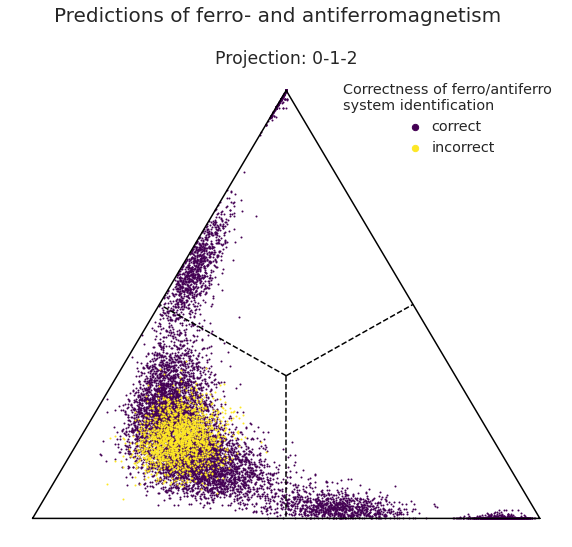

In [213]:
#idx = np.random.permutation(len(correct))  # mix them a bit
plot_ternary(data_out[idx]**2, correct, np.unique(correct), class_names = ["correct", "incorrect"],
             size=10, plt_title = "Predictions of ferro- and antiferromagnetism",
             legend_title = "Correctness of ferro/antiferro\nsystem identification")

## 4. Visualize filters and activations

## Visualize activations

In [215]:
def get_activation_model(mdl):
    layer_outputs = [layer.output for layer in mdl.layers]
    
    # Construct model outputing all layer activations
    return Model(inputs=mdl.inputs, outputs=layer_outputs)

In [216]:
def show_activations(img, activation_mdl, layer_num, size=5):

    # get activation outputs
    activation = activation_mdl.predict(img)[layer_num]

    n_features = activation.shape[-1]
    
    #colswitch = {1: 1, 2: 2, 3: 2, 4: 2}
    #ncols = colswitch.get(n_features, 3)
    ncols = 4
    nrows = 1 + (n_features - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size*ncols, size*nrows))
    axes = np.ravel(axes)

    fig.suptitle(f"Activations", fontsize = 20)
    
    for i in range(n_features):
        axes[i].imshow(activation[0, :, :, i], cmap='gray')
        
    for i in range(n_features, nrows*ncols):
        axes[i].axis('off')

In [217]:
def show_probs(img, activation_mdl):
    
    activation = activation_mdl.predict(img)[-1]
    n_features = activation.shape[-1]
    plt.bar([str(i) for i in range(n_features)], activation[0,:])

In [218]:
mdl = get_activation_model(mdl_embed)

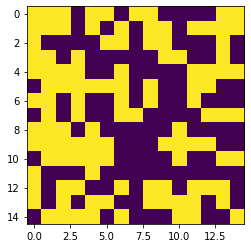

In [238]:
img = cfgs['t100'][600][np.newaxis, :, :, np.newaxis]
plt.imshow(img[0,:,:,0])

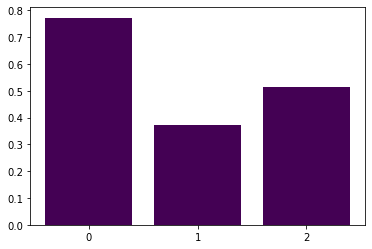

In [239]:
show_probs(img, mdl)

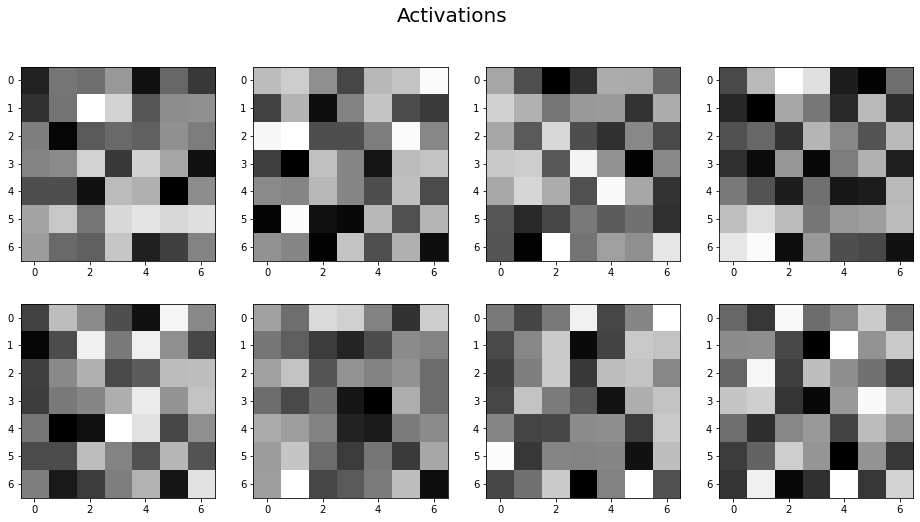

In [241]:
show_activations(img, mdl, layer_num=0, size=4)

### Visualize filters

In [ ]:
mdl_embed.summary()

In [ ]:
layer_name = 'conv2d_24'
filter_index = 0

layer_output = mdl_embed.get_layer(layer_name).output
loss = tf.reduce_mean(layer_output[:, :, :, filter_index])

mdl_embed.get_input_at(1)

# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = tf.GradientTape.gradients(loss, mdl_embed.get_input_at(0))[0]

# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([mdl_embed.get_input_at(0)], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 15, 15, 1))])

# We start from a gray image with some noise
input_img_data = np.random.random((1, 15, 15, 1))

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=15):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = discriminator.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, discriminator.get_input_at(0))[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([discriminator.get_input_at(0)], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 1))

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return img #deprocess_image(img)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

xfig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()

target_data = np.array(cfgs['t2'][-768:])
target_data.shape

# Set hyperparameters
iterations = 20001
batch_size = 64
sample_interval = 200

# Train the DCGAN for the specified number of iterations
train(target_data, iterations, batch_size, sample_interval)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()